**BPNN Matrix Image Resize 70x70**

Import Library

In [529]:
import os
import pickle 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
import numpy as np
import math
from numpy.random import normal

Flatten

In [ ]:
input_directory = "../Dataset/Foto_Resize_Rotate_70x70"

# List all folders in the input directory
folders = [f for f in os.listdir(input_directory) if os.path.isdir(os.path.join(input_directory, f))]
print(f"Found folders: {folders}")

# Initialize arrays for inputs and outputs
X = []
Y = []

# Create a mapping from folder names to one-hot encoded labels
label_map = {folder: idx for idx, folder in enumerate(folders)}
num_classes = len(folders)

# Process each folder and photo
for folder in folders:
    folder_path = os.path.join(input_directory, folder)
    
    # Sort the list of photos to ensure consistent order
    photos = sorted([p for p in os.listdir(folder_path) if p.endswith(('.png', '.jpg', '.jpeg'))])
    
    for photo in photos:
        photo_path = os.path.join(folder_path, photo)
        image = Image.open(photo_path)
        
        # Convert the image to a numpy array and flatten it
        image_array = np.array(image).flatten()
        X.append(image_array)
        
        # Create a one-hot encoded label
        label = np.zeros(num_classes)
        label[label_map[folder]] = 1
        Y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
X = X/255;
Y = np.array(Y)

print(f"Input array shape: {X.shape}")
print(f"Output array shape: {Y.shape}")

import numpy as np

def split_data(X, Y, train_ratio, val_ratio):
  # Acak data
  num_samples = X.shape[0]  # Assume X and Y have the same number of samples
  indices = np.arange(num_samples)
  np.random.shuffle(indices)

  # Cari banyak data atau indeks yang akan digunakan untuk training dan validasi
  train_idx = int(train_ratio * num_samples)
  val_idx = int((train_ratio + val_ratio) * num_samples)

  # Split data
  X_train = X[indices[:train_idx]]
  Y_train = Y[indices[:train_idx]]
  X_val = X[indices[train_idx:val_idx]]
  Y_val = Y[indices[train_idx:val_idx]]
  X_test = X[indices[val_idx:]]
  Y_test = Y[indices[val_idx:]]

  # Kembalikan X Y untuk training, validasi, dan testing
  return X_train, Y_train, X_val, Y_val, X_test, Y_test



In [522]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X, Y, train_ratio=0.5, val_ratio=0.25)

Functions

In [523]:
def ReLU(x):
    return np.maximum(0, x)
    
def Softmax(x):
    exp = np.exp(x-np.max(x, axis = 0))
    return exp/np.sum(exp, axis = 0)


def d_ReLU(x):
    return x > 0

def ELU(x):
    if(x<0):
        return 0.005*(np.exp(x)-1)
    if(x>=0):
        return x

def d_ELU(x):
    if(x<0):
        return ELU(x)+0.005
    if(x>=0):
        return 1


Defining Variables and Biases

In [524]:
inputNeurons = 4900
hiddenLayer = 1
outputNeurons = 15
hiddenNeurons = 30

stddev = np.sqrt(2 / inputNeurons)
v = np.random.normal(loc=0, scale = stddev, size = (inputNeurons, hiddenNeurons))
v = v.T
print(np.shape(v))
vb = np.random.normal(loc=0, scale=stddev, size=hiddenNeurons) 
vb = vb.reshape(hiddenNeurons,1)
print(np.shape(vb))
stddev = np.sqrt(2 / hiddenNeurons)
w = np.random.normal(loc=0, scale = stddev, size = (hiddenNeurons, outputNeurons))
w = w.T
print(np.shape(w))
wb = np.random.normal(loc=0, scale = stddev, size = outputNeurons)
wb = wb.reshape(15,1)
print(np.shape(wb))

X = X_train.T
Y = Y_train.T



(30, 4900)
(30, 1)
(15, 30)
(15, 1)


**Main BPNN Process using ReLU and Softmax** 

Training

In [525]:
for i in range(1000):

    z_in = np.dot(v,X) + vb
    z = ReLU(z_in)

    y_in = np.dot(w,z) + wb
    y = Softmax(y_in)
    
    sigma_k = y-Y

    delta_w = (1/X.shape[1])*np.dot(sigma_k,z.T)
    delta_wb = (1/X.shape[1])*np.sum(sigma_k)

    sigma_in = np.dot(w.T,sigma_k)*d_ReLU(z_in)

    delta_v = (1/X.shape[1])*np.dot(sigma_in,X.T)
    delta_vb = (1/X.shape[1])*np.sum(sigma_in)

    alpha = 0.005
    w -= alpha*delta_w
    wb -= alpha*delta_wb
    v -= alpha*delta_v
    vb -= alpha*delta_vb


In [526]:
import shelve
with shelve.open('WeightDB') as db:
        db['v'] = v
        db['vb'] = vb
        db['w'] = w
        db['wb'] = wb

Validation

In [527]:
X = X_val.T
Y = Y_val.T

with shelve.open('WeightDB') as db:
        v = db['v']
        vb = db['vb']
        w = db['w']
        wb = db['wb']

def validation(X, v, vb, w, wb):
    z_in = np.dot(v,X) + vb
    z = ReLU(z_in)
    y_in = np.dot(w,z) + wb
    y = Softmax(y_in)
    return y


# Prediksi
Y_pred = validation(X, v, vb, w, wb)


Testing

Akurasi: 0.9080459770114943


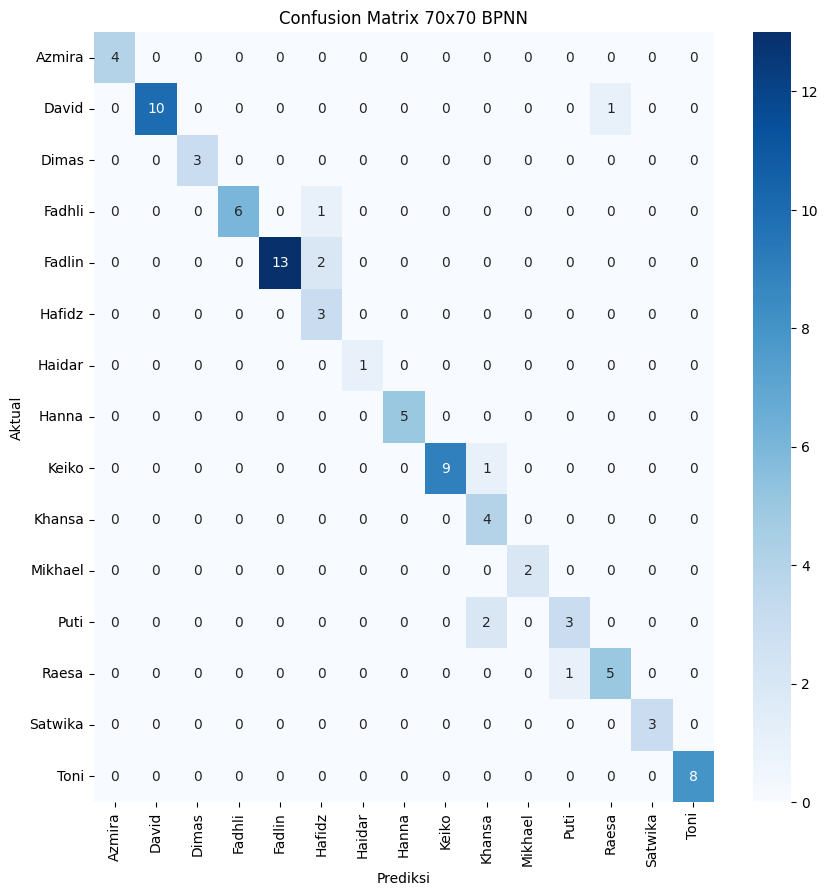

In [528]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

X = X_test.T
Y = Y_test.T

def test(X, v, vb, w, wb):
    z_in = np.dot(v, X) + vb
    z = ReLU(z_in)
    y_in = np.dot(w, z) + wb
    y = Softmax(y_in)  # Assuming you have defined the Softmax function
    return y

# Fungsi Feedforward (untuk prediksi output)
Y_pred = test(X, v, vb, w, wb)

# Nama sesuai urutan folder
nama = ['Azmira', 'David', 'Dimas', 'Fadhli', 'Fadlin', 'Hafidz', 'Haidar', 'Hanna', 'Keiko', 'Khansa', 'Mikhael', 'Puti', 'Raesa', 'Satwika', 'Toni']

prediksi = np.argmax(Y_pred, axis = 0) # mencari baris dengan nilai tertinggi untuk tiap data, ukuran Y_pred = (15, 52)

aktual = np.argmax(Y, axis = 0) # mencari baris dengan nilai tertinggi untuk tiap data, ukuran Y = (15, 52)

# Mencari Confusion Matrix
confusionMatrix = confusion_matrix(prediksi, aktual)

# Mencari Akurasi
akurasi = accuracy_score(aktual, prediksi)
print(f"Akurasi: {akurasi}") # tampilkan akurasi

# Tampilkan Confusion Matrix
plt.figure(figsize = (10,10))
sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", xticklabels=nama, yticklabels=nama)
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix 70x70 BPNN")
plt.show()